Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read Data

In [2]:
file = pd.ExcelFile("../../../data/v7/Handball 3. Liga vom 23.01.2023.xlsx")

file.sheet_names

df = file.parse('3. Liga')

# drop last col comments
df = df.iloc[:, :-1]
df.columns

Index(['Heimmannschaft', 'Gastmannschaft', 'Spieltag', 'Name', 'Spielminute',
       'Differenz Pfiff 1 und 2 (in Sekunden)', 'Tore Verein', 'Tore Gegner',
       'Torwartposition (1 = vorne, 2 = hinten)',
       'Wurf erfolgreich (0= Nein, 1 = Ja, 2 = im Nachwurf)',
       'L-R-Händer (1= Rechtshänder; 2= Linkshänder)', 'Wurfrichtung (1-9)?',
       'Drucksituation?\n0 = Nein, 1 = Torwartwechsel\n2 = letzter 7 Meter gehalten\n3 = Tordifferenz =< 4 + ab 50. Spielminute\n4 = 1 + 2, 5 = 1 + 3, 6 = 2 + 3, 7 = 1 + 2 + 3, 8 = letzer 7-Meter erst im Nachwurf erfolgreich',
       'Anzahl 7-Meter im Spiel (der wievielte 7-Meter im Spiel vom Spieler)',
       'Wurfquadrant des letzten 7-Meters (1-9)',
       'letzter 7-Meter erfolgreich \n(1= ja; 0= Nein; 2 = im Nachwurf erfolgreich)?'],
      dtype='object')

Cleanup & Renaming

In [3]:
df.replace('unklar', np.nan,inplace=True)
df.replace('unklar ', np.nan,inplace=True)
df.replace('fehlend', np.nan,inplace=True)
#df.dropna(inplace=True)
df.replace('-', np.nan,inplace=True)
df.columns =[ 'homeTeam','opponentTeam','day','name','playTime',
              'whistleThrowTime','homeGoals','opponentGoals','goalKeeperPosition',
              'throwSuccess','LRHandy','throwDirection','pressureSituation','noOfThrowsFromPlayer',
              'throwQuadrantLastThrow','lastThrowSuccess']
df = df.astype({'homeTeam':'string', 'opponentTeam':'string','day':'float16','name':'string','playTime':'float16',
              'homeGoals':'float16','opponentGoals':'float16','whistleThrowTime':'float16','goalKeeperPosition':'float16',
              'throwSuccess':'float16','LRHandy':'float16','throwDirection':'float16','pressureSituation':'float16','noOfThrowsFromPlayer':'float16',
              'throwQuadrantLastThrow':'float16','lastThrowSuccess':'float16' })

General Summary

In [4]:
ps = df.loc[:,('throwSuccess','pressureSituation')].copy()
ps.dropna(inplace=True)
ps['throwSuccess'].replace(2.0, 1.0,inplace=True)
s = [0, 1,4,5,7]
ps = ps[ps.pressureSituation.isin(s) == True]
ps['pressureSituation'].replace(4.0, 1.0,inplace=True)
ps['pressureSituation'].replace(5.0, 1.0,inplace=True)
ps['pressureSituation'].replace(7.0, 1.0,inplace=True)
# print(ps)
# X_ps = ['No Pressure Situation','GoalKeeperChange','LastThrowFailed',
#      'GoalDiffLessEqualTo4After50MinPlay','GoalKeeperChange-LastThrowFailed',
#      'GoalKeeperChange-GoalDiffLessEqualTo4After50MinPlay','LastThrowFailed-GoalDiffLessEqualTo4After50MinPlay',
#      'GoalKeeperChange-LastThrowFailed-GoalDiffLessEqualTo4After50MinPlay',
#      'FirstInNachWurf']
# for i,s in enumerate(X_ps):
#     ps['pressureSituation'].replace(i, s,inplace=True)

# print(ps)
# ps1 =pd.DataFrame(ps.groupby('throwSuccess').pressureSituation.value_counts()).unstack()
# ps1
contigency= pd.crosstab(ps['throwSuccess'], ps['pressureSituation'], margins=True, margins_name="Total") 
contigency



pressureSituation,0.0,1.0,Total
throwSuccess,,,
0.0,57,7,64
1.0,225,52,277
Total,282,59,341


throwSuccess,Failed,Success
pressureSituation,,
GoalKeeper Changed,0.118644,0.881356
Same GoalKeeper,0.202128,0.797872


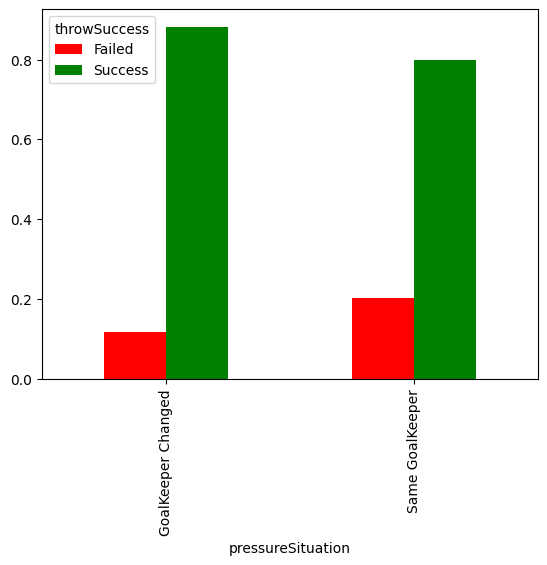

In [5]:
#contigency_pct = pd.crosstab(ps['throwSuccess'], ps['pressureSituation'], normalize='all', margins=True, margins_name="Total")
dfpct = ps.copy()
dfpct['pressureSituation'].replace(0.0,'Same GoalKeeper',inplace=True)
dfpct['pressureSituation'].replace(1.0,'GoalKeeper Changed',inplace=True)
dfpct['throwSuccess'].replace(0.0,'Failed',inplace=True)
dfpct['throwSuccess'].replace(1.0,'Success',inplace=True)
contigency_pct = pd.crosstab(dfpct['pressureSituation'],dfpct['throwSuccess'], normalize='index')
contigency_pct.plot(kind='bar',stacked=False,color={"Failed": "red", "Success": "green"})
contigency_pct

In [6]:
from scipy.stats import chi2_contingency


# null hypo : no significant association between pressure situation and throwsuccess
# research hypo : There is relation between pressure situation and throwsuccess
# for df=1 & alpha=0.05 c =1(Chi-square table)
contigencychi= pd.crosstab(ps['throwSuccess'], ps['pressureSituation']) 
c, p, dof, expected = chi2_contingency(contigencychi) 
print(c,p,dof)
print(expected)
#c > 3.84  Null Hypo accepted with 5% error

# Also,
# P-value ≤ α: The variables have a statistically significant association (Reject H0)
# If the p-value is less than or equal to the significance level, you reject the null hypothesis and conclude that there is a statistically significant association between the variables.
# P-value > α: Cannot conclude that the variables are associated (Fail to reject H0)
# If the p-value is larger than the significance level, you fail to reject the null hypothesis because there is not enough evidence to conclude that the variables are associated.

1.7165030641399048 0.19014380038282191 1
[[ 52.92668622  11.07331378]
 [229.07331378  47.92668622]]


Changing Goalkeeper increses the chances of Throw Success but as per Chi Square Test we can conclude that there is no statistically significant association between Throw Success and Pressure Situation with 5% error.